### This is a Starter Notebook for Stock Price Prediction using Linear Regression



### About the Dataset - 
The dataset has around 60 features which includes features extracted from OHLC, other index prices such as QQQ(Nasdaq-100 ETF) & S&P 500, technical Indicators such as Bollinger bands, EMA(Exponential Moving Averages, Stocastic %K oscillator, RSI etc)

Furthermore, I have created lagged features from previous day price data as we know previous day prices affect the future stock price. 

Then, the data has date features which specifies, if its a leap year, if its month start or end, Quarter start or end, etc. 


All of these features have something to offer for forcasting. Some tells us about the trend, some gives us a signal if the stock is overbought or oversold, some portrays the strength of the price trend.



In this notebook, I will analyse the data and create a basic Linear regression model to forecast Stock Prices. 
In future notebooks, I will use other algorithms like Random Forest, XGBoost and LSTM for this task. 


I will also create a Notebook explaining how I have extracted this data using only OHLC(Open High Low Close) data.

In [62]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import seaborn as sns
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
%matplotlib inline


### Loading data

I will use the Apple Stock Data for this notebook

In [63]:
Stock = pd.read_csv('/content/AAPL.csv')
df_Stock = Stock

In [64]:
# Renaming column name Close(t) to Close
df_Stock = df_Stock.rename(columns={'Close(t)':'Close'})

In [65]:
# first 5 rows of data
df_Stock.head()

,Date,Open,High,Low,Close,Volume,SD20,Upper_Band,Lower_Band,S_Close(t-1),...,QQQ_MA10,QQQ_MA20,QQQ_MA50,SnP_Close,SnP(t-1)),SnP(t-5),DJIA_Close,DJIA(t-1)),DJIA(t-5),Close_forcast
0,2005-10-17,6.66,6.69,6.50,6.60,154208600,0.169237,6.827473,6.150527,6.67,...,33.692,33.9970,34.2690,1190.10,1186.57,1187.33,10348.10,10287.34,10238.76,6.45
1,2005-10-18,6.57,6.66,6.44,6.45,152397000,0.168339,6.819677,6.146323,6.60,...,33.570,33.9525,34.2466,1178.14,1190.10,1184.87,10285.26,10348.10,10253.17,6.78
2,2005-10-19,6.43,6.78,6.32,6.78,252170800,0.180306,6.861112,6.139888,6.45,...,33.562,33.9600,34.2330,1195.76,1178.14,1177.68,10414.13,10285.26,10216.91,6.93
3,2005-10-20,6.72,6.97,6.71,6.93,339440500,0.202674,6.931847,6.121153,6.78,...,33.567,33.9455,34.2190,1177.80,1195.76,1176.84,10281.10,10414.13,10216.59,6.87
4,2005-10-21,7.02,7.03,6.83,6.87,199181500,0.216680,6.974860,6.108140,6.93,...,33.586,33.9365,34.2034,1179.59,1177.80,1186.57,10215.22,10281.10,10287.34,7.01


In [66]:
# last 5 rows of the data
df_Stock.tail(5)

,Date,Open,High,Low,Close,Volume,SD20,Upper_Band,Lower_Band,S_Close(t-1),...,QQQ_MA10,QQQ_MA20,QQQ_MA50,SnP_Close,SnP(t-1)),SnP(t-5),DJIA_Close,DJIA(t-1)),DJIA(t-5),Close_forcast
3727,2020-08-07,452.82,454.70,441.17,444.45,49453300,27.954399,455.316298,343.498702,454.79,...,266.054,263.4085,252.2098,3351.28,3349.16,3271.12,27433.48,27386.98,26428.32,450.91
3728,2020-08-10,450.40,455.10,440.00,450.91,53100900,29.847338,462.586675,343.197325,444.45,...,267.073,263.9970,252.9570,3360.47,3351.28,3294.61,27791.44,27433.48,26664.40,437.50
3729,2020-08-11,447.88,449.93,436.43,437.50,46975600,30.576290,466.543079,344.237921,450.91,...,267.911,264.2380,253.5878,3333.69,3360.47,3306.51,27686.91,27791.44,26828.47,452.04
3730,2020-08-12,441.99,453.10,441.19,452.04,41486200,32.050532,472.583564,344.381436,437.50,...,269.120,264.7860,254.3206,3380.35,3333.69,3327.77,27976.84,27686.91,27201.52,460.04
3731,2020-08-13,457.72,464.17,455.71,460.04,52520500,33.532634,479.279768,345.149232,452.04,...,270.255,265.4540,255.0446,3373.43,3380.35,3349.16,27896.72,27976.84,27386.98,459.63


### EDA

In [67]:
df_Stock.shape

(3732, 64)

In [68]:
df_Stock.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'SD20', 'Upper_Band',
       'Lower_Band', 'S_Close(t-1)', 'S_Close(t-2)', 'S_Close(t-3)',
       'S_Close(t-5)', 'S_Open(t-1)', 'MA5', 'MA10', 'MA20', 'MA50', 'MA200',
       'EMA10', 'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'MACD_EMA',
       'ATR', 'ADX', 'CCI', 'ROC', 'RSI', 'William%R', 'SO%K', 'STD5',
       'ForceIndex1', 'ForceIndex20', 'Date_col', 'Day', 'DayofWeek',
       'DayofYear', 'Week', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
       'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Is_leap_year',
       'Year', 'Month', 'QQQ_Close', 'QQQ(t-1)', 'QQQ(t-2)', 'QQQ(t-5)',
       'QQQ_MA10', 'QQQ_MA20', 'QQQ_MA50', 'SnP_Close', 'SnP(t-1))',
       'SnP(t-5)', 'DJIA_Close', 'DJIA(t-1))', 'DJIA(t-5)', 'Close_forcast'],
      dtype='object')

In [69]:
df_Stock=df_Stock.drop(['Date'], axis=1)

In [77]:
df_Stock.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SD20', 'Upper_Band',
       'Lower_Band', 'S_Close(t-1)', 'S_Close(t-2)', 'S_Close(t-3)',
       'S_Close(t-5)', 'S_Open(t-1)', 'MA5', 'MA10', 'MA20', 'MA50', 'MA200',
       'EMA10', 'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'MACD_EMA',
       'ATR', 'ADX', 'CCI', 'ROC', 'RSI', 'William%R', 'SO%K', 'STD5',
       'ForceIndex1', 'ForceIndex20', 'Date_col', 'Day', 'DayofWeek',
       'DayofYear', 'Week', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
       'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Is_leap_year',
       'Year', 'Month', 'QQQ_Close', 'QQQ(t-1)', 'QQQ(t-2)', 'QQQ(t-5)',
       'QQQ_MA10', 'QQQ_MA20', 'QQQ_MA50', 'SnP_Close', 'SnP(t-1))',
       'SnP(t-5)', 'DJIA_Close', 'DJIA(t-1))', 'DJIA(t-5)', 'Close_forcast'],
      dtype='object')

## Pivot-Table and its graph

In [70]:
# pivot table between DayofWeek and mean of Close_forecast in that week
df_Stock.groupby('DayofWeek')[['Close_forcast']].mean()

,Close_forcast
DayofWeek,
0,87.715164
1,87.678914
2,86.820326
3,87.587636
4,87.114626


In [71]:
# pivot table between DayofWeek and Month with respect to mean of the Close_forecast in that week
df_Stock.groupby(['DayofWeek', 'Month'])['Close_forcast'].aggregate('mean').unstack()

Month,1,2,3,4,5,6,7,8,9,10,11,12
DayofWeek,,,,,,,,,,,,
0,81.215217,84.883261,84.967727,88.405538,88.275000,96.128154,100.063437,91.288095,85.415652,83.119846,80.634762,84.909355
1,83.003281,85.533000,85.366818,87.933906,89.791642,96.634062,98.763538,92.423333,82.510167,86.223438,79.954375,83.358889
2,82.623231,84.565574,82.898769,88.385231,91.705373,92.179524,101.299219,93.989385,82.728814,85.124769,80.754923,74.753065
3,85.466308,84.514167,83.669104,88.485625,91.067313,92.382031,98.835625,95.605846,82.823559,84.042500,83.095600,79.445469
4,84.679531,83.807377,84.599206,85.352500,93.659851,93.446769,98.915410,89.329531,83.676500,81.187778,85.021538,80.951111


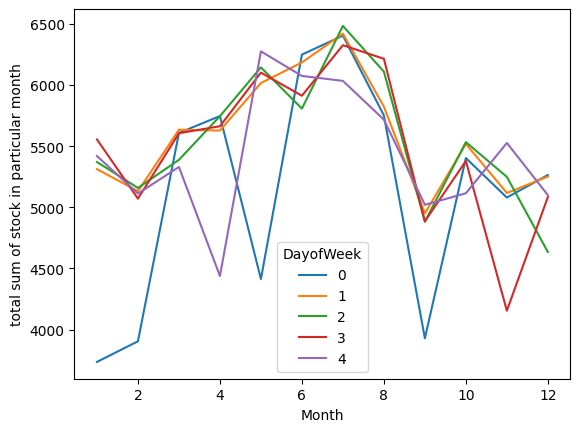

In [72]:
df_Stock.pivot_table('Close_forcast', index='Month', columns='DayofWeek', aggfunc='sum').plot()
plt.ylabel('total sum of stock in particular month');

### Visualising Null values in Dataset

<Axes: >

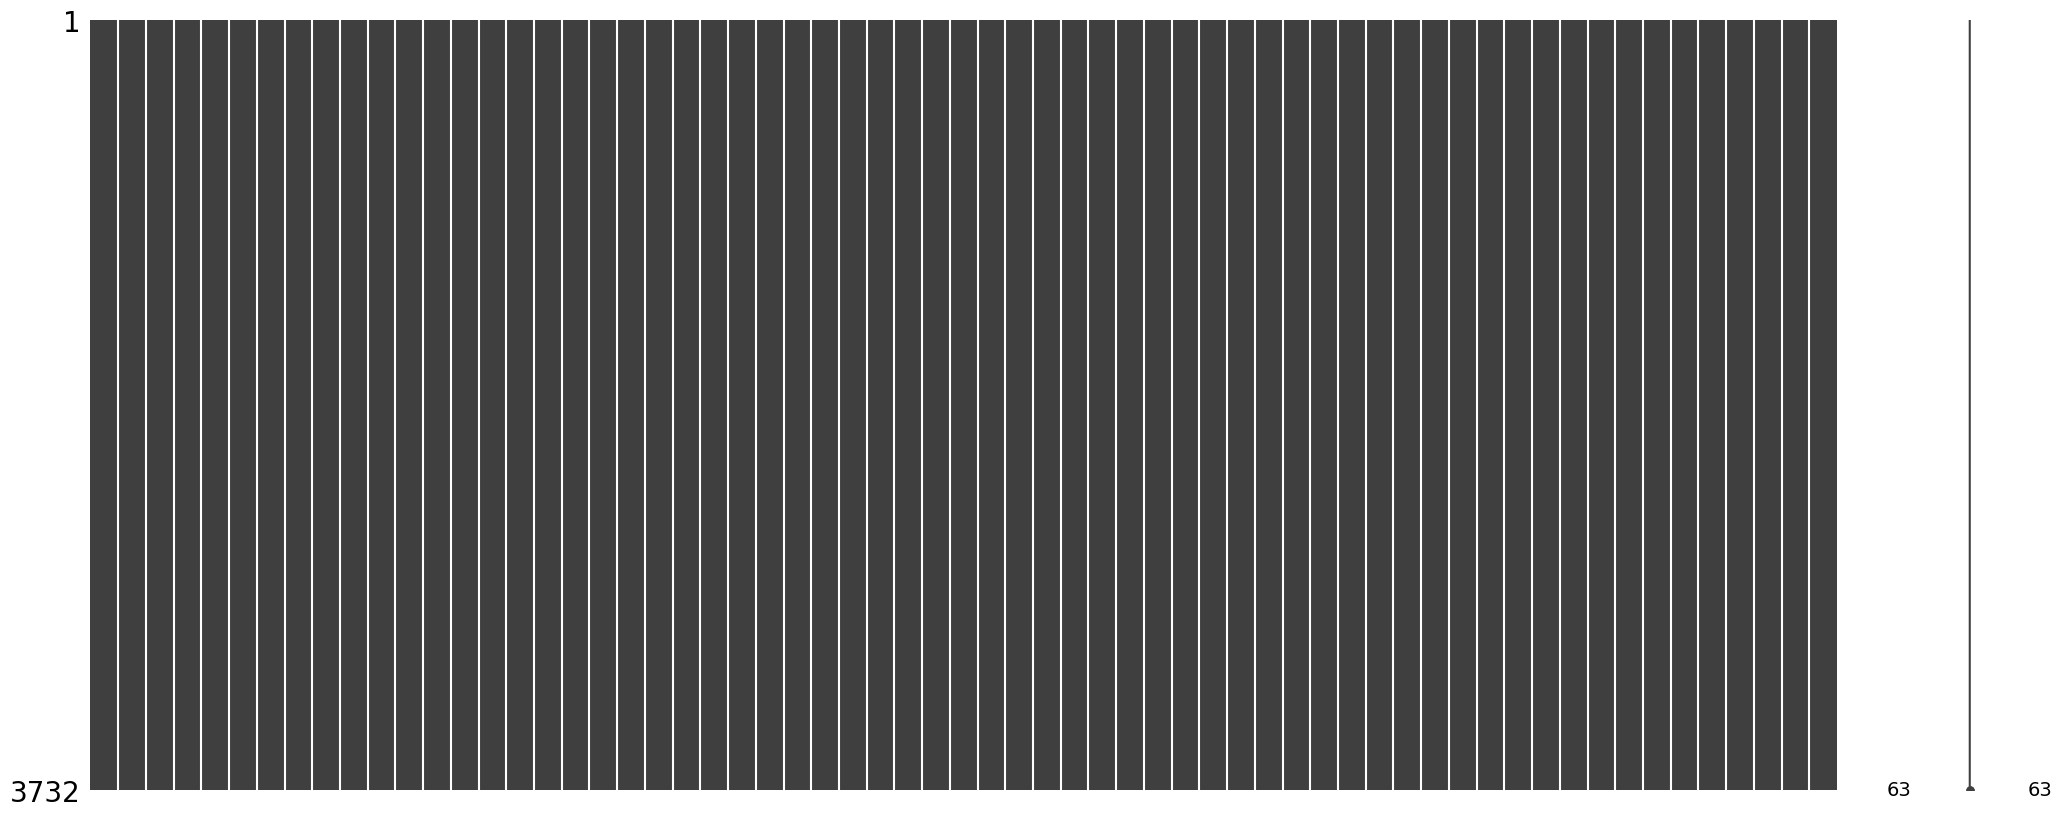

In [73]:
import missingno as msno 
msno.matrix(df_Stock)

### Plot Time Series chart for AAPL

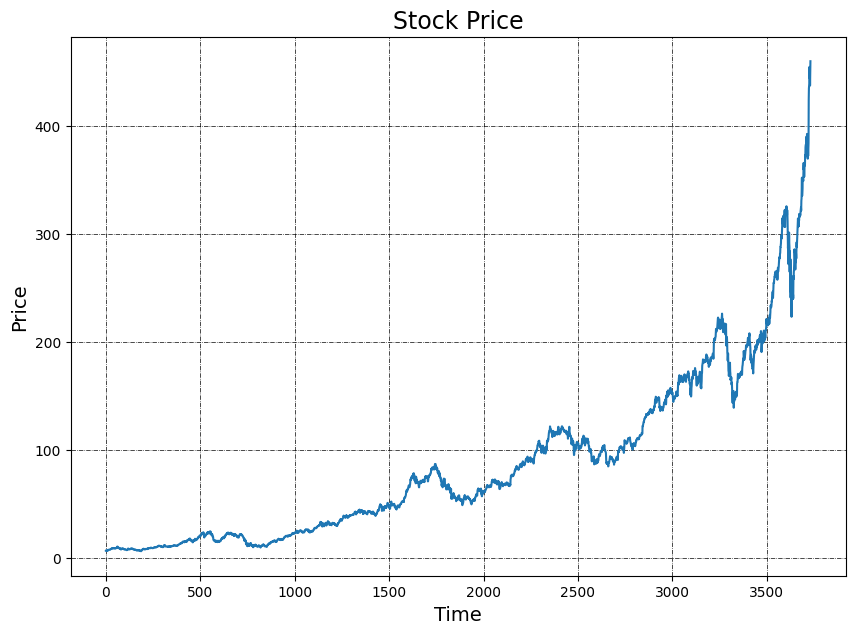

In [74]:
df_Stock['Close'].plot(figsize=(10, 7))
plt.title("Stock Price", fontsize=17)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

Remove some of the columns which are not required

In [7]:
df_Stock = df_Stock.drop(columns='Date_col')

### Test Train Set

Close_forecast is the column that we are trying to predict here which is the price for the next day. 

In [48]:
def create_train_test_set(df_Stock):
    
    features = df_Stock.drop(columns=['Close_forcast'], axis=1)
    target = df_Stock['Close_forcast']
    

    data_len = df_Stock.shape[0]
    print('Historical Stock Data length is - ', str(data_len))

    #create a chronological split for train and testing
    train_split = int(data_len * 0.88)
    print('Training Set length - ', str(train_split))

    val_split = train_split + int(data_len * 0.1)
    print('Validation Set length - ', str(int(data_len * 0.1)))

    print('Test Set length - ', str(int(data_len * 0.02)))

    # Splitting features and target into train, validation and test samples 
    X_train, X_val, X_test = features[:train_split], features[train_split:val_split], features[val_split:]
    Y_train, Y_val, Y_test = target[:train_split], target[train_split:val_split], target[val_split:]

    #print shape of samples
    print(X_train.shape, X_val.shape, X_test.shape)
    print(Y_train.shape, Y_val.shape, Y_test.shape)
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [49]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = create_train_test_set(df_Stock)

Historical Stock Data length is -  3732
Training Set length -  3284
Validation Set length -  373
Test Set length -  74
(3284, 62) (373, 62) (75, 62)
(3284,) (373,) (75,)


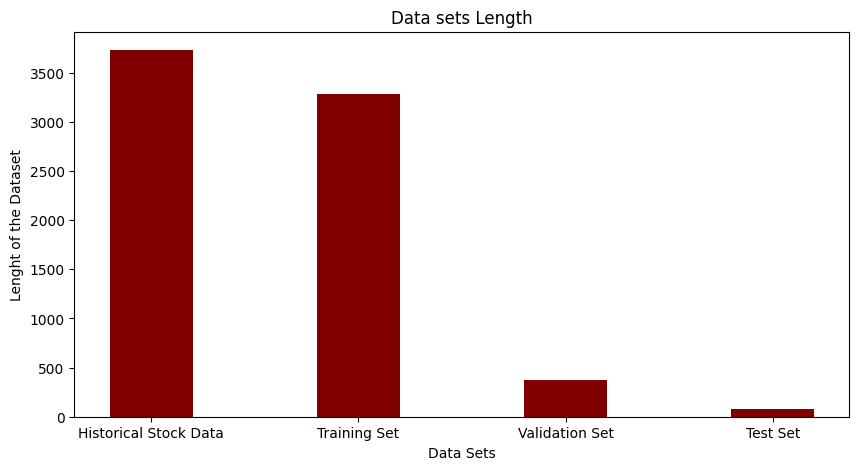

In [45]:
data = {'Historical Stock Data':3732, 'Training Set':3284, 'Validation Set':373,'Test Set':74}
col = list(data.keys())
value = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
plt.bar(col, value, color ='maroon', width = 0.4)
plt.xlabel("Data Sets")
plt.ylabel("Lenght of the Dataset")
plt.title("Data sets Length")
plt.show()

### Prediction using Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

In [11]:
print('LR Coefficients: \n', lr.coef_)
print('LR Intercept: \n', lr.intercept_)

LR Coefficients: 
 [ 8.63720651e-03  1.86051924e-01  1.55487061e-01  1.12263757e+00
  1.27286976e-10  6.75244700e-03  1.40229152e-01  1.13219364e-01
  4.25627561e-02  8.96348479e-02  1.01914952e-01  5.94183536e-02
  7.95194233e-02  7.10399945e-02  2.71425000e-01  1.26724258e-01
  8.79333221e-02 -5.87980378e-03 -3.31643390e-01 -3.31643390e-01
 -3.31643390e-01 -3.31643390e-01 -3.31643390e-01  1.88650006e+00
 -1.27270717e+00 -1.65042222e-01 -4.36658326e-04 -3.21581043e-12
 -5.07434282e-03  9.02936549e-03  5.78316988e-04  5.78316984e-04
 -5.57918089e-01 -2.02305062e-10  4.18931556e-11  1.69322438e-02
  1.61636704e-02 -1.75659582e-02  6.12165520e-03  2.15420350e-01
  1.13979655e-01 -2.41954674e-01  7.63050309e-02  3.73276597e-01
 -1.66533454e-16 -5.60843989e-02  4.08788806e-02  5.13473863e-01
 -2.94431539e-02 -8.41335081e-02  5.10939135e-02 -8.14435710e-03
 -1.95035197e-02  5.67587251e-02  4.39707788e-02  1.29311738e-02
 -9.99967545e-03 -3.89778364e-03 -1.62174814e-03  1.44436900e-03
  2.83

### Evaluation

In [12]:
print("Performance (R^2): ", lr.score(X_train, Y_train))

Performance (R^2):  0.9994516474373267


In [13]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Predict for the test dataset

In [14]:
Y_train_pred = lr.predict(X_train)
Y_val_pred = lr.predict(X_val)
Y_test_pred = lr.predict(X_test)

In [80]:
from prettytable import PrettyTable
 
# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Dataset Type", "R-squared", "Explained Variation", "MAPE", "Mean Squared Error", "RMSE", "MAE"])
 
# Add rows
myTable.add_row(["Training", round(metrics.r2_score(Y_train,Y_train_pred),2), round(metrics.explained_variance_score(Y_train,Y_train_pred),2), round(get_mape(Y_train,Y_train_pred), 2), round(metrics.mean_squared_error(Y_train,Y_train_pred), 2), round(np.sqrt(metrics.mean_squared_error(Y_train,Y_train_pred)),2), round(metrics.mean_absolute_error(Y_train,Y_train_pred),2)])
myTable.add_row(["Validation", round(metrics.r2_score(Y_val,Y_val_pred),2), round(metrics.explained_variance_score(Y_val,Y_val_pred),2), round(get_mape(Y_val,Y_val_pred), 2) , round(metrics.mean_squared_error(Y_train,Y_train_pred), 2), round(np.sqrt(metrics.mean_squared_error(Y_val,Y_val_pred)),2), round(metrics.mean_absolute_error(Y_val,Y_val_pred),2)])
myTable.add_row(["Test", round(metrics.r2_score(Y_test,Y_test_pred),2), round(metrics.explained_variance_score(Y_test,Y_test_pred),2), round(get_mape(Y_test,Y_test_pred), 2), round(metrics.mean_squared_error(Y_test,Y_test_pred), 2), round(np.sqrt(metrics.mean_squared_error(Y_test,Y_test_pred)),2), round(metrics.mean_absolute_error(Y_test,Y_test_pred),2)])
print(myTable)


+--------------+-----------+---------------------+------+--------------------+------+------+
| Dataset Type | R-squared | Explained Variation | MAPE | Mean Squared Error | RMSE | MAE  |
+--------------+-----------+---------------------+------+--------------------+------+------+
|   Training   |    1.0    |         1.0         | 1.45 |        1.48        | 1.22 | 0.76 |
|  Validation  |    0.99   |         0.99        | 1.68 |        1.48        | 5.91 | 3.75 |
|     Test     |    0.96   |         0.97        | 1.77 |       79.21        | 8.9  | 6.5  |
+--------------+-----------+---------------------+------+--------------------+------+------+


# OR


In [15]:
print("Training R-squared: ",round(metrics.r2_score(Y_train,Y_train_pred),2))
print("Training Explained Variation: ",round(metrics.explained_variance_score(Y_train,Y_train_pred),2))
print('Training MAPE:', round(get_mape(Y_train,Y_train_pred), 2)) 
print('Training Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
print("Training RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_train,Y_train_pred)),2))
print("Training MAE: ",round(metrics.mean_absolute_error(Y_train,Y_train_pred),2))

print(' ')

print("Validation R-squared: ",round(metrics.r2_score(Y_val,Y_val_pred),2))
print("Validation Explained Variation: ",round(metrics.explained_variance_score(Y_val,Y_val_pred),2))
print('Validation MAPE:', round(get_mape(Y_val,Y_val_pred), 2)) 
print('Validation Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
print("Validation RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_val,Y_val_pred)),2))
print("Validation MAE: ",round(metrics.mean_absolute_error(Y_val,Y_val_pred),2))

print(' ')

print("Test R-squared: ",round(metrics.r2_score(Y_test,Y_test_pred),2))
print("Test Explained Variation: ",round(metrics.explained_variance_score(Y_test,Y_test_pred),2))
print('Test MAPE:', round(get_mape(Y_test,Y_test_pred), 2)) 
print('Test Mean Squared Error:', round(metrics.mean_squared_error(Y_test,Y_test_pred), 2)) 
print("Test RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_test,Y_test_pred)),2))
print("Test MAE: ",round(metrics.mean_absolute_error(Y_test,Y_test_pred),2))

Training R-squared:  1.0
Training Explained Variation:  1.0
Training MAPE: 1.45
Training Mean Squared Error: 1.48
Training RMSE:  1.22
Training MAE:  0.76
 
Validation R-squared:  0.99
Validation Explained Variation:  0.99
Validation MAPE: 1.68
Validation Mean Squared Error: 1.48
Validation RMSE:  5.91
Validation MAE:  3.75
 
Test R-squared:  0.96
Test Explained Variation:  0.97
Test MAPE: 1.77
Test Mean Squared Error: 79.21
Test RMSE:  8.9
Test MAE:  6.5


We have a decent Mean Absolute error but not great. I will create further tuned models in later notebooks. This is just to get you started with the dataset.

In [16]:
df_pred = pd.DataFrame(Y_val.values, columns=['Actual'], index=Y_val.index)
df_pred['Predicted'] = Y_val_pred
df_pred = df_pred.reset_index()
df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')
df_pred

<ipython-input-16-eb2d0977aa50>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')


,Date,Actual,Predicted
0,2018-11-01,202.30,216.289778
1,2018-11-02,196.56,201.470182
2,2018-11-05,198.68,195.948933
3,2018-11-06,204.71,199.043601
4,2018-11-07,204.00,204.193666
...,...,...,...
368,2020-04-22,273.79,275.751755
369,2020-04-23,281.70,274.020243
370,2020-04-24,281.90,280.710045
371,2020-04-27,277.33,280.543603


### Plot Predicted vs Actual Prices on Time Series plot

<Axes: >

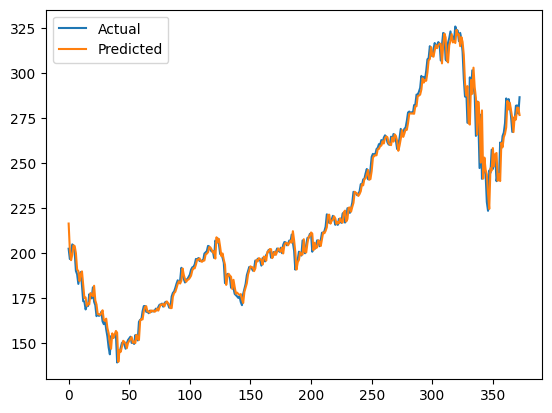

In [17]:
df_pred[['Actual', 'Predicted']].plot()

Overall the Predictions looks good for the test data! 

### Future Notebooks

I will create a Notebook explaining how I have extracted this data using only OHLC(Open High Low Close) data and a custom pipeline